In [ ]:
#| default_exp process

# process

> Image processing submodule.

In [ ]:
#| hide 
# %pylab inline
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
from nbdev.showdoc import *
from nbdev import *

In [ ]:
#| exporti
import configparser
from fastcore.basics import patch
from os.path import expanduser
from astroquery.astrometry_net import AstrometryNet
from astroquery.exceptions import TimeoutError as ASTTimeoutError
from ouscope.core import Telescope
from ouscope.solver import Solver

from IPython import display

import time
from datetime import datetime
import os
from requests import session
from bs4 import BeautifulSoup
from io import StringIO, BytesIO
from zipfile import ZipFile
from astropy.io import fits
from astropy.coordinates import SkyCoord, Longitude, Latitude
import astropy.units as u
from astropy.wcs import WCS
from astropy.io import fits
from astropy.visualization import simple_norm
from astroquery.vizier import Vizier
from tqdm.auto import tqdm
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.path import Path
import numpy as np
from photutils.detection import DAOStarFinder
from astropy.stats import sigma_clipped_stats
from numpy import argsort
from sqlitedict import SqliteDict

from astropy.visualization import make_lupton_rgb

import astroalign as aa
from collections import namedtuple
from ouscope.vs import get_VS_sequence

In [ ]:
#| hide
#| exporti
plt.rcParams['image.cmap'] = 'gray'

In [ ]:
#| login
config = configparser.ConfigParser()
config.read(expanduser('~/.config/telescope.ini'))

ast = AstrometryNet()
ast.api_key = config['astrometry.net']['apikey']
solver = Solver(config['astrometry.net']['apikey'])

In [ ]:
#| login
OSO=Telescope(config='~/.config/telescope.ini')

In [ ]:
Job = namedtuple('Job', 'jid rid done')

In [ ]:
DB = SqliteDict('telescope.sqlite', autocommit=True)
VSdb = SqliteDict('vstars.sqlite', autocommit=True)

In [ ]:
if not ('done' in DB):
    DB['done'] = set()
if not ('problematic' in DB):
    DB['problematic'] = set()
done = DB['done']
problematic = DB['problematic']

In [ ]:
# VSdb['BE Vul']

In [ ]:
for vs in VSdb.items():
    if 'seq' in vs[1] and vs[1]['seq'] and vs[1]['seq'][0] and vs[1]['seq'][1]:
        print(vs[0], len(vs[1]['jobs']) )
    else :
        # print(vs)
        pass

V686 Cyg 1
V994 Cyg 1
V1285 Cyg 1
V1288 Cyg 1
V1993 Cyg 1
LV Cyg 1
LX Cyg 1
LY Cyg 1
V681 Cyg 1
V682 Cyg 1
V2173 Cyg 1
V2657 Cyg 1
EQ Lyr 2
V476 Lyr 2
V588 Lyr 2
ST Vul 1
SW Vul 1
CF Vul 1
DQ Vul 1
V418 Vul 1
V433 Vul 1
V434 Vul 1
V452 Vul 1
V498 Vul 1
V571 Vul 1
IN Cyg 1
IP Cyg 1
V1278 Cyg 1
V1280 Cyg 1
V1990 Cyg 1


In [ ]:
#| exporti
def make_color_image(layers, black=1.0, Q=5, stretch=200, mults=(0.95, 1.0, 1.0), order='BVR'):

    seq = argsort(list(order))
    b, r, g = (m*layers[l] for m,l in zip(mults,seq))
    # print([order[i] for i in seq])
    
    try :
        r_r, r_f = aa.register(r, g, detection_sigma=10)
    except TypeError:
        r_r = r
        
    try :
        b_r, b_f = aa.register(b, g, detection_sigma=10)
    except TypeError:
        b_r = b
        
    minlev = np.array([sigma_clipped_stats(l, sigma=3.0)[1] for l in (r,g,b)])
    return make_lupton_rgb(0.9*r_r, g, b_r, minimum=black*minlev, Q=Q, stretch=stretch)

In [ ]:
#| export
verts = [
    (0, 0.5),
    (0.3, 0.5),
    (0.7, 0.5),
    (1, 0.5),
]
verts = verts + [(y, x) for x, y in verts]
verts = [(y-0.5, x-0.5) for x, y in verts]
codes = 4*[Path.MOVETO, Path.LINETO]
marker = Path(verts, codes)

In [ ]:
#| export
def plot_sequence(vs):
    if vs in VSdb:
        seq = VSdb[vs]['seq']
        if not seq[0]:
            return
    ax = plt.gca()
    ax.text(0, 0, seq[0], color='C1')
    for s in seq[1]:
        print(s)
        dx = 20/3600
        ax.plot(s[3], s[5], marker=marker, lw=1, color='C2', ms=30, transform=ax.get_transform('world'))
        ax.text(s[3]+dx, s[5]-dx, s[1], color='white', transform=ax.get_transform('world'))

In [ ]:
#| export
def process_job(jid, reprocess=False, cls=True, layer=None):
    job = OSO.get_job(jid)
    ctime = job['completion']
    req = OSO.get_request(int(job['rid'].split()[0]))
    target = req['name'].lstrip().rstrip()
    print(f'jid {jid}: ({target})')
    print(f'{" ".join(ctime)}')
    z = OSO.get_obs(job, cube=False, verbose=False)    
    hdul=[fits.open(BytesIO(z.read(name)))[0] for name in z.namelist()]
    if layer is not None:
        hdul=[hdul[layer]]
    # hdul = fits.open(OSO.get_obs(job, cube=True, verbose=False))
    print(f'Filters: {tuple(hdu.header["FILTER"] for hdu in hdul)}')
    if not reprocess and jid in DB :
        print('Done')
        if cls:
            display.clear_output(wait=True);
        return
    hi = min(1, len(hdul)-1)
    # hi = 0
    for hdu in hdul:
        wcs_head = solver.solve(hdu, tout=30)
        if wcs_head:
            break
    if not wcs_head:
        print('Cannot solve image')
        OSO.get_obs(job, cube=True, verbose=False)
        data = hdul[hi].data[:-32,:-32]
        plt.imshow(data, norm=simple_norm(data, 'asinh', asinh_a=0.01))
        plt.show();
        return
    w = WCS(wcs_head)
    box = w.calc_footprint()
    c = box.mean(axis=0)
    s = box.max(axis=0) - box.min(axis=0)
    result = Vizier.query_region(catalog='B/gcvs', 
                                 coordinates=SkyCoord(*c, unit='deg', frame='fk5'), 
                                 width=f'{s[0]}deg', height=f'{s[1]}deg')
#     for g in result:
#         for n, o in enumerate(g):
#             if 'Name' in o.keys():
#                 name = o['Name']
#             elif 'GCVS' in o.keys():
#                 name = ' '.join(o['GCVS'].split())
#             elif 'NSV' in o.keys():
#                 name = f'NSV_{o["NSV"]}'

#             print(f'{name:12} {o["magMax"]:6.2f}', o)
    ax = plt.subplot(projection=w)
    plt.grid(color='white', ls='solid')
    for g in result:
        print(g)
        for n, o in enumerate(g):
            if 'Name' in o.keys():
                name = o['Name']
            elif 'GCVS' in o.keys():
                name = ' '.join(o['GCVS'].split())
            elif 'NSV' in o.keys():
                name = f'NSV_{o["NSV"]}'
            else :
                name = f'VS_{n}'
            if name.startswith('V0'):
                name = 'V'+name[2:]
            if name in VSdb:
                jobl = VSdb[name]
            else :
                jobl = {}
                jobl['jobs']=set()
            jobl['jobs'] |= {jid}
            VSdb[name]=jobl
            try :
                frame='icrs'
                try :
                    radec = SkyCoord(o['RAJ2000'] + o['DEJ2000'], 
                                     frame=frame, unit=(u.hourangle, u.deg))
                except ValueError:
                    radec = SkyCoord(o['RAJ2000'], o['DEJ2000'], 
                                     frame=frame, unit=(u.deg, u.deg))                    
            except KeyError:
                    radec =  SkyCoord(o['_RA.icrs'] + o['_DE.icrs'], 
                                     frame='icrs', unit=(u.hourangle, u.deg))
                    frame='icrs'
#                     radec =  SkyCoord(o['RAB1950'] + o['DEB1950'], 
#                                      frame='fk4', unit=(u.hourangle, u.deg))
            ax.plot(radec.ra.deg, radec.dec.deg, marker=marker, color='C1', ms=30,
                    transform=ax.get_transform('world'), )#edgecolor='yellow', facecolor='none')
            ax.text(radec.ra.deg+0.012, radec.dec.deg-0.012, f'{name} ({o["magMax"]:.1f})', 
                    transform=ax.get_transform('world'), color='white')
            if name.lstrip().rstrip().lower() == target.lower():
                plot_sequence(target)
                
    if cls :
        display.clear_output(wait=True)
        print(f'jid {jid}: ({target})')
        print(f'{" ".join(ctime)}')
        print(f'Filters: {tuple(hdu.header["FILTER"] for hdu in hdul)}')

    try :
        if len(hdul)==3:
            plt.imshow(make_color_image([hdu.data[:-32,:-32] for hdu in hdul], order=tuple(hdu.header["FILTER"] for hdu in hdul)))
        else :
            data = hdul[hi].data[:-32,:-32]
            plt.imshow(data, norm=simple_norm(data, 'asinh', asinh_a=0.01))
    except aa.MaxIterError:
        data = hdul[hi].data[:-32,:-32]
        plt.imshow(data, norm=simple_norm(data, 'asinh', asinh_a=0.01))
    DB[jid]=Job(jid, [int(rid[1:]) for rid in job['rid'].split()], True)
    plt.show()
    display.display(plt.gcf());    

In [ ]:
#| export
def analyse_job(jid, rid=None, reprocess=False):
    job = OSO.get_job(jid)
    ctime = job['completion']
    if rid is None:
        rid=int(job['rid'].split()[0])
    req = OSO.get_request(rid)
    target = req['name'].lstrip().rstrip()
    print(f'J{jid}:R{rid} ({target}) {" ".join(ctime)}')
    z = OSO.get_obs(job, cube=False, verbose=False)
    hdul=[fits.open(BytesIO(z.read(name)))[0] for name in z.namelist()]
    print(f'Filters: {" ".join(hdu.header["FILTER"] for hdu in hdul)}')
    if not reprocess and jid in DB:
        print('Done')
        return
    hi = min(1, len(hdul)-1)
    # hi = 0
    for hdu in hdul:
        wcs_head = solver.solve(hdu, tout=30)
        if wcs_head:
            break
    if not wcs_head:
        print('Cannot solve image')
        OSO.get_obs(job, cube=True, verbose=False)
        return
    w = WCS(wcs_head)
    box = w.calc_footprint()
    c = box.mean(axis=0)
    s = box.max(axis=0) - box.min(axis=0)
    result = Vizier.query_region(catalog='B/gcvs', 
                                 coordinates=SkyCoord(*c, unit='deg', frame='fk5'), 
                                 width=f'{s[0]}deg', height=f'{s[1]}deg')
    for g in result:
        for n, o in enumerate(g):
            if 'Name' in o.keys():
                name = o['Name']
            elif 'GCVS' in o.keys():
                name = ' '.join(o['GCVS'].split())
            elif 'NSV' in o.keys():
                name = f'NSV_{o["NSV"]}'
            else :
                name = f'VS_{n}'
            if name.startswith('V0'):
                name = 'V'+name[2:]
            if name in VSdb:
                jobl = VSdb[name]
            else :
                jobl = {}
                jobl['jobs']=set()
                jobl['seq']=None
            try :
                jobl['jobs'] |= {jid}
            except TypeError:
                jobl['jobs'] = {jid}
            if not jobl['seq']:
                try :
                    seq = get_VS_sequence(name, 40, 16)
                except ConnectionError:
                    time.sleep(5)
                    seq = get_VS_sequence(name, 40, 16)
                if seq[0] and seq[1]:
                    jobl['seq']=seq
            VSdb[name]=jobl
            print(f'{name}', end=" ")
            if jobl["seq"] and jobl["seq"][0] and jobl["seq"][1]:
                print(f'seq:{jobl["seq"][0]} ({len(jobl["seq"][1])})')
            else :
                print()                      
    DB[jid]=Job(jid, [int(rid[1:]) for rid in job['rid'].split()], True)
    return True

In [ ]:
#| login
reqlst=OSO.get_user_requests(sort='completion')
print(f'Number of users requests: {len(reqlst)}')

complete = [rq for rq in sorted(reqlst, key=lambda r: int(r['requesttime']), reverse=True) 
                    if Telescope.REQUESTSTATUS_TEXTS[int(rq['status'])]=='Complete']
print('Completed:', len(complete))

Number of users requests: 1700
Completed: 1679


J412679:R759658 (EQ Lyr) 9 December 2023 19:36:32 UTC
Filters: V B R
Getting 93A98C3F from cache
EQ Lyr seq:X35373APC (9)
V476 Lyr seq:X35373APD (3)
V588 Lyr seq:X35373APE (8)


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


jid 412679: (EQ Lyr)
9 December 2023 19:36:32 UTC
Filters: ('V', 'B', 'R')
Getting 93A98C3F from cache
   GCVS   n_GCVS   RAJ2000     DEJ2000   VarType magMax Period SpType Exists  VarName  Simbad
                                                  mag     d                                  
--------- ------ ----------- ----------- ------- ------ ------ ------ ------ --------- ------
   EQ Lyr      x 19 19 02.63 +41 06 34.5       M 12.000     --               EQ    Lyr Simbad
V0476 Lyr      x 19 19 49.83 +40 47 08.2      LB 10.500     --               V0476 Lyr Simbad
V0588 Lyr      x 19 19 55.00 +40 52 40.0     SRA 12.500     --               V0588 Lyr Simbad
['000-BKK-100', '107', '19:19:08.67', 289.78613281, '41:06:39.6', 41.11100006, '12.415 (0.079)', '10.675 (0.053)', '1.740 (0.095)', '9.820 (0.106)']
['000-BKK-101', '110', '19:18:28.61', 289.61920166, '41:10:29.4', 41.17483521, '11.797 (0.032)', '10.988 (0.017)', '0.809 (0.036)', '10.571 (0.060)']
['000-BKK-102', '114', '19:19:19.2

a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


['000-BKK-106', '131', '19:18:43.56', 289.68148804, '41:06:11.6', 41.10322189, '13.759 (0.049)', '13.098 (0.029)', '0.661 (0.057)', '12.805 (0.058)']
['000-BKK-107', '138', '19:19:05.88', 289.77450562, '41:02:18.5', 41.03847122, '14.621 (0.043)', '13.836 (0.025)', '0.785 (0.050)', '13.428 (0.142)']
['000-BKK-108', '142', '19:19:00.07', 289.75030518, '41:02:45.0', 41.04583359, '14.850 (0.049)', '14.157 (0.026)', '0.693 (0.055)', '13.816 (0.134)']


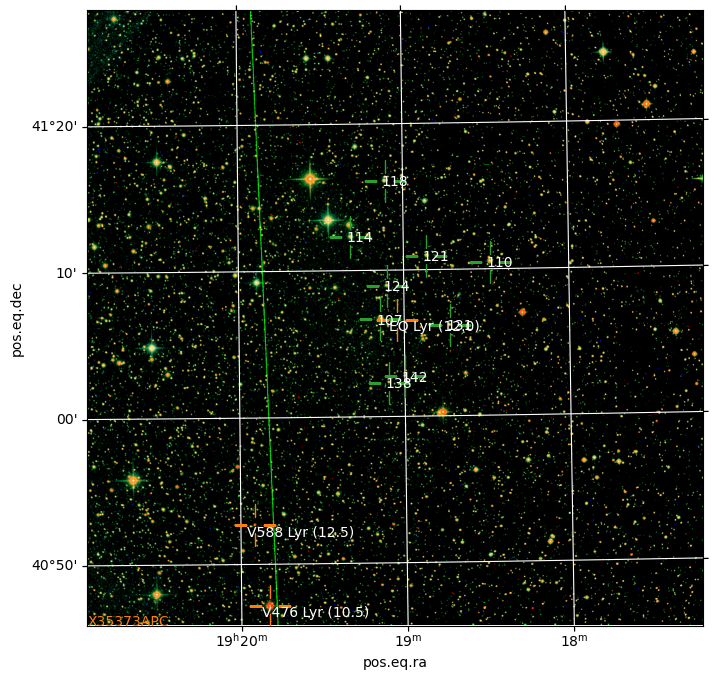

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

J412676:R759655 (DQ Vul) 9 December 2023 19:48:49 UTC
Filters: R V B
Getting 55C0F8D2 from cache
ST Vul seq:X35373APJ (19)
SW Vul seq:X35373APK (15)
CF Vul seq:X35373APL (18)
DQ Vul seq:X35373APM (14)
V418 Vul seq:X35373APN (4)
V433 Vul seq:X35373APO (14)
V434 Vul seq:X35373APP (14)
V452 Vul seq:X35373APQ (14)
V498 Vul seq:X35373APR (14)
V571 Vul seq:X35373APS (11)


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


NSV_24959 
jid 412676: (DQ Vul)
9 December 2023 19:48:49 UTC
Filters: ('R', 'V', 'B')
Getting 55C0F8D2 from cache
   GCVS   n_GCVS   RAJ2000     DEJ2000   VarType magMax      Period      SpType Exists  VarName  Simbad
                                                  mag          d                                       
--------- ------ ----------- ----------- ------- ------ ---------------- ------ ------ --------- ------
   ST Vul      x 20 01 13.00 +23 06 34.0         11.000               --               ST    Vul Simbad
   SW Vul      x 20 00 05.21 +22 56 06.6    UGSS 14.500    15.0000000000               SW    Vul Simbad
   CF Vul      x 20 00 54.55 +23 05 45.8      LB 12.800               --     Me        CF    Vul Simbad
   DQ Vul      x 20 00 03.01 +22 46 51.7       M 14.500   310.0000000000               DQ    Vul Simbad
V0418 Vul        19 59 41.89 +22 33 49.6      M: 13.600               --               V0418 Vul Simbad
V0433 Vul      x 20 00 32.54 +22 40 15.4     SR: 10.30

a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


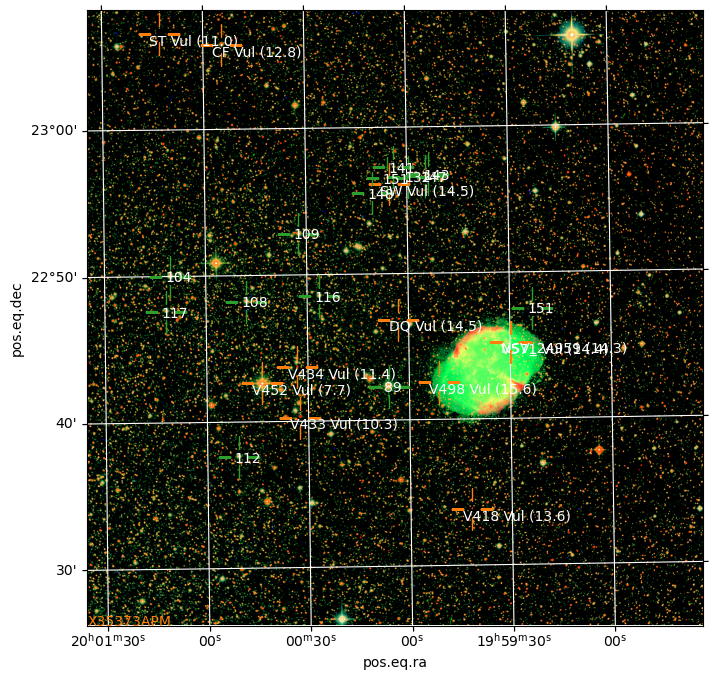

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

J412674:R759653 (IP Cyg) 9 December 2023 19:59:09 UTC
Filters: R V B
Getting 4F0A8ABD from cache
IN Cyg seq:X35373APW (22)
IP Cyg seq:X35373APX (12)
V1278 Cyg seq:X35373APY (15)
V1280 Cyg seq:X35373APZ (20)


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


V1445 Cyg 
V1446 Cyg 
V1990 Cyg seq:X35373AQC (23)
NSV_24881 
jid 412674: (IP Cyg)
9 December 2023 19:59:09 UTC
Filters: ('R', 'V', 'B')
Getting 4F0A8ABD from cache
   GCVS   n_GCVS   RAJ2000     DEJ2000   VarType magMax      Period      SpType Exists  VarName  Simbad
                                                  mag          d                                       
--------- ------ ----------- ----------- ------- ------ ---------------- ------ ------ --------- ------
   IN Cyg      x 19 44 04.90 +34 31 07.5       M 12.500   287.0000000000               IN    Cyg Simbad
   IP Cyg      x 19 44 40.09 +34 49 37.7       M 12.000   406.0000000000    M10        IP    Cyg Simbad
V1278 Cyg      x 19 42 57.34 +34 44 58.5       M 14.800   290.0000000000               V1278 Cyg Simbad
V1280 Cyg      x 19 43 43.72 +34 40 53.9       M 14.500   405.0000000000               V1280 Cyg Simbad
V1445 Cyg        19 46 17.28 +35 02 20.8      M: 16.100   320.0000000000               V1445 Cyg Simbad
V14

a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


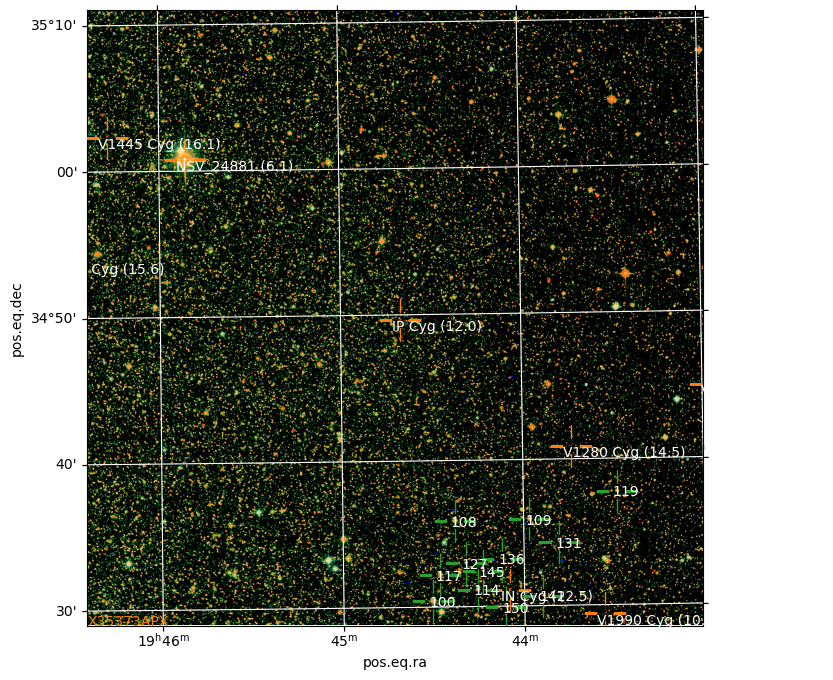

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

J412675:R759654 (V686 Cyg) 9 December 2023 20:09:27 UTC
Filters: R V B
Solving for C878BD5B
solve-field -p -l 30 -O -L 1 -H 2 -u app -3 296.754167 -4 35.829722 -5 2 /tmp/field-solveryitv1hll/tmpz6ddhflb.fits
Solving for 252A20E6
solve-field -p -l 30 -O -L 1 -H 2 -u app -3 296.754167 -4 35.829722 -5 2 /tmp/field-solverihc1a2re/tmpelgtq2nq.fits
Getting 20CAB792 from cache
V686 Cyg seq:X35373AQN (8)
V994 Cyg seq:X35373AQO (9)
V1285 Cyg seq:X35373AQP (5)
V1288 Cyg seq:X35373AQQ (14)
V1993 Cyg seq:X35373AQR (9)


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


NSV_12402 
jid 412675: (V686 Cyg)
9 December 2023 20:09:27 UTC
Filters: ('R', 'V', 'B')
Solving for C878BD5B
solve-field -p -l 30 -O -L 1 -H 2 -u app -3 296.754167 -4 35.829722 -5 2 /tmp/field-solverktuw4fox/tmpaoi9gm_0.fits
Solving for 252A20E6
solve-field -p -l 30 -O -L 1 -H 2 -u app -3 296.754167 -4 35.829722 -5 2 /tmp/field-solver1i1wuizr/tmpoq5jqwrh.fits
Getting 20CAB792 from cache
   GCVS   n_GCVS   RAJ2000     DEJ2000   VarType magMax      Period      SpType Exists  VarName  Simbad
                                                  mag          d                                       
--------- ------ ----------- ----------- ------- ------ ---------------- ------ ------ --------- ------
V0686 Cyg      x 19 47 01.13 +35 49 47.5       M 11.900   320.0000000000               V0686 Cyg Simbad
V0994 Cyg      x 19 49 09.98 +35 41 21.5    RRAB 16.000     0.6009538000               V0994 Cyg Simbad
V1285 Cyg      * 19 44 49.53 +35 59 34.9    UGZ: 13.100               --               V12

a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


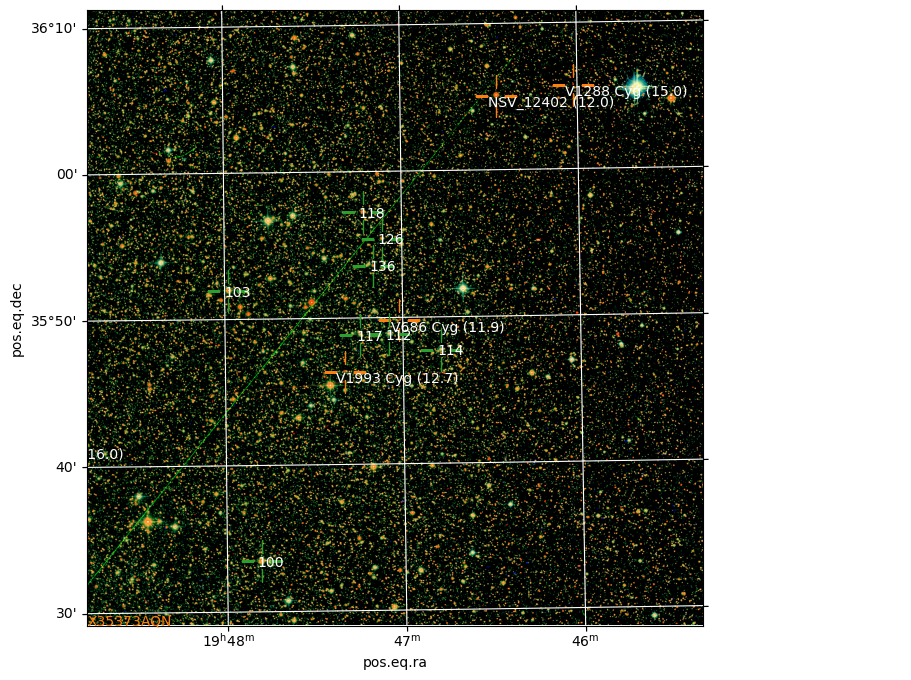

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

J412518:R759483 (LX Cyg) 8 December 2023 20:02:41 UTC
Filters: R V B
Getting 1D4BD0D3 from cache
LV Cyg seq:X35373AQE (41)
LX Cyg seq:X35373AQF (44)
LY Cyg seq:X35373AQG (40)
V681 Cyg seq:X35373AQH (32)
V682 Cyg seq:X35373AQI (13)
V2173 Cyg seq:X35373AQJ (9)
V2657 Cyg seq:X35373AQK (17)


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


NSV_13959 
NSV_25782 
jid 412518: (LX Cyg)
8 December 2023 20:02:41 UTC
Filters: ('R', 'V', 'B')
Getting 1D4BD0D3 from cache
   GCVS   n_GCVS   RAJ2000     DEJ2000   VarType magMax      Period         SpType   Exists  VarName  Simbad
                                                  mag          d                                            
--------- ------ ----------- ----------- ------- ------ ---------------- ----------- ------ --------- ------
   LV Cyg      x 21 55 08.02 +48 13 48.2       M 11.300   370.4000000000          M7        LV    Cyg Simbad
   LX Cyg      * 21 55 57.07 +48 20 50.9       M 11.500   465.3000000000 SC3e-S5,5e:        LX    Cyg Simbad
   LY Cyg      x 21 56 10.40 +48 04 13.3       M 14.200   286.0000000000          M5        LY    Cyg Simbad
V0681 Cyg      x 21 55 25.24 +48 29 24.8      EA 14.300     3.4042900000                    V0681 Cyg Simbad
V0682 Cyg      x 21 56 23.65 +48 37 54.6      LB 12.900               --          M6        V0682 Cyg Simbad
V21

a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


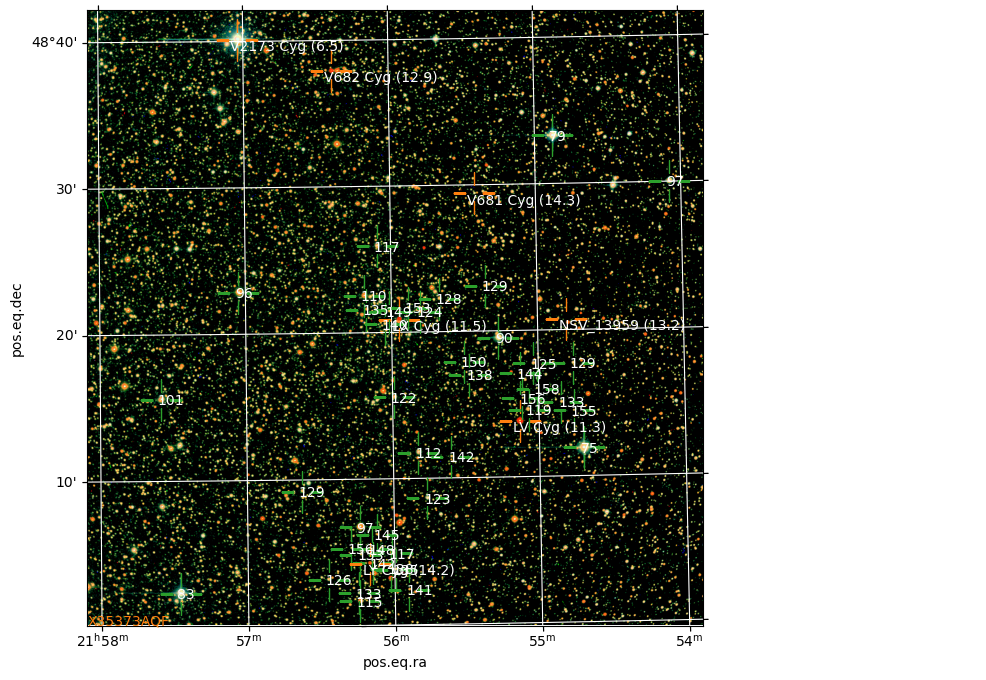

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
#| login
for r in complete[:5]:
    j = OSO.get_request(int(r['id']))
    o = OSO.get_job(int(j['jid']))
    f = OSO.get_obs(o, verbose=True)

    analyse_job(o['jid'], reprocess=True)
    
    plt.figure(figsize=(8,8))
    process_job(o['jid'], reprocess=True, cls=False)
    plt.show()

In [ ]:
# for jid in VSdb['BI Her']['jobs']:
#     if jid in problematic:
#         print(f'{jid} problematic')
#         continue
#     analyse_job(jid, reprocess=True)
#     plt.figure(figsize=(8,8))
#     process_job(jid, reprocess=True, cls=False)
#     plt.show()

In [ ]:
#| login

userjobs = ((int(OSO.get_request(int(j['id']))['jid']), int(j['id'])) for j in complete[:3])
for n, (jid, rid) in enumerate(userjobs):
    if jid in (problematic | done):
        continue
    print(f"{n}:R{rid}:J{jid}")
    try :
        if analyse_job(jid, rid, True):
            done |= {jid}
    except ConnectionError:
        print('Unable to finish')

0:R759658:J412679
J412679:R759658 (EQ Lyr) 9 December 2023 19:36:32 UTC
Filters: V B R
Getting 93A98C3F from cache
EQ Lyr seq:X35373APC (9)
V476 Lyr seq:X35373APD (3)
V588 Lyr seq:X35373APE (8)
1:R759655:J412676


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


J412676:R759655 (DQ Vul) 9 December 2023 19:48:49 UTC
Filters: R V B
Getting 55C0F8D2 from cache
ST Vul seq:X35373APJ (19)
SW Vul seq:X35373APK (15)
CF Vul seq:X35373APL (18)
DQ Vul seq:X35373APM (14)
V418 Vul seq:X35373APN (4)
V433 Vul seq:X35373APO (14)
V434 Vul seq:X35373APP (14)
V452 Vul seq:X35373APQ (14)
V498 Vul seq:X35373APR (14)
V571 Vul seq:X35373APS (11)


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


NSV_24959 
2:R759653:J412674
J412674:R759653 (IP Cyg) 9 December 2023 19:59:09 UTC
Filters: R V B
Getting 4F0A8ABD from cache


a floating-point value was expected. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


IN Cyg seq:X35373APW (22)
IP Cyg seq:X35373APX (12)
V1278 Cyg seq:X35373APY (15)
V1280 Cyg seq:X35373APZ (20)
V1445 Cyg 
V1446 Cyg 
V1990 Cyg seq:X35373AQC (23)
NSV_24881 
